# COMP5329 - Assignment1 


**Semester 1, 2019**

## Loading the packages

In [295]:
import numpy as np
import matplotlib.pyplot as pl
from ipywidgets import interact, widgets
from matplotlib import animation
import h5py
with h5py.File('train_128.h5','r') as H: data = np.copy(H['data'])
with h5py.File('train_label.h5','r') as H: label = np.copy(H['label'])
with h5py.File('test_128.h5','r') as H:
    test_data = np.copy(H['data'])

## Data Preprocessing

Preprocess data with Z-score Standardisation

In [296]:
data1 = np.zeros(data.shape)
data_len = len(data)
for i in range(data_len):
    data1[i] = (data[i]- np.mean(data[i],axis=0)) / np.std(data[i], axis = 0)
    

In [297]:
test_data1 = np.zeros(test_data.shape)
test_len = len(test_data)
for i in range(test_len):
    test_data1[i] = (test_data[i]- np.mean(test_data[i],axis=0)) / np.std(test_data[i], axis = 0)

## Definition of some activation functions

Linear
$$output = x$$

Relu
$$output = relu(x)$$

Tanh  
$$output = tanh(x)$$  

Sigmoid
$$output = \frac {1}{1 + e^{-x}}$$

In [298]:
class Activation(object):
    def __tanh(self, x):
        return np.tanh(x)

    def __tanh_deriv(self, a):
        # a = np.tanh(x)   
        return 1.0 - a**2
    def __logistic(self, x):
        return 1.0 / (1.0 + np.exp(-x))

    def __logistic_deriv(self, a):
        # a = logistic(x) 
        return  a * (1 - a )
    def __relu(self, x):
        new_x=np.zeros(x.shape)
        r=x.shape[0]
        c=x.shape[1]
        for i in range(r):
            for j in range(c):
                re=x[i][j]             
                if re>0:
                    new_x[i][j]=re
                else:
                    continue
        return new_x
    def __relu_deriv(self, a):
        
        new_a=np.zeros(a.shape)
        r=a.shape[0]
        c=a.shape[1]
        for i in range(r):
            for j in range(c):
                re=a[i][j]             
                if re>0:
                    new_a[i][j]=1.
                else:
                    new_a[i][j]=0
        return new_a
        
        
    def __init__(self,activation='tanh'):
        if activation == 'logistic':
            self.f = self.__logistic
            self.f_deriv = self.__logistic_deriv
        elif activation == 'tanh':
            self.f = self.__tanh
            self.f_deriv = self.__tanh_deriv
        elif activation=='relu':
            self.f=self.__relu
            self.f_deriv = self.__relu_deriv

# Define HiddenLayer

$$output = f\_act(\sum_{i=0}^{1}{(I_{i} * W_{i})} + b)$$

In [306]:
class HiddenLayer(object):    
    def __init__(self,n_in, n_out,
                 activation_last_layer='relu',activation='relu', W=None, b=None):
        """
        Typical hidden layer of a MLP: units are fully-connected and have
        sigmoidal activation function. Weight matrix W is of shape (n_in,n_out)
        and the bias vector b is of shape (n_out,).

        NOTE : The nonlinearity used here is tanh

        Hidden unit activation is given by: tanh(dot(input,W) + b)

        :type n_in: int
        :param n_in: dimensionality of input

        :type n_out: int
        :param n_out: number of hidden units

        :type activation: string
        :param activation: Non linearity to be applied in the hidden
                           layer
        """
        self.input=None
        self.activation=Activation(activation).f
        # define parameters of dropout
        self.sample=None
        # define parameters of batch normalization
        self.run_mean=None
        self.run_var=None
        self.cache=None
        self.gamma= np.ones(n_in,)
        self.beta = np.zeros(n_in,)
        # activation deriv of last layer
        self.activation_deriv=None
        self.grad_gamma=np.zeros(n_in,)
        self.grad_beta=np.zeros(n_in,)
        
        if activation_last_layer:
            self.activation_deriv=Activation(activation_last_layer).f_deriv       
        ##Initialize weight using HE.
        self.W = np.random.randn(n_in, n_out) / np.sqrt(n_in / 2)
        self.v = np.zeros((n_in,n_out))
        
        if activation == 'logistic':
            self.W *= 4

        self.b = np.zeros((1,n_out))
        
        self.grad_W = np.zeros(self.W.shape)
        self.grad_b = np.zeros(self.b.shape)
    
    #define forward function with dropout
    def forward_d(self, input):
        '''
        :type input: numpy.array
        :param input: a symbolic tensor of shape (n_in,)
        '''

        #self.run_mean=np.zeros(input.shape[1])
        #self.run_var=np.zeros(input.shape[1])
        
        #momentum=0.9
        input1=self.dropout(input)
        #input_bn=np.zeros(input1.shape)
        
        #x_mean = np.mean(input1,axis=0)
        #l_mean=len(x_mean)
        #x_mean=x_mean.reshape(1,l_mean)###############
       # x_std=np.std(input1,axis=0)
        #l_std=len(x_std)
        #x_std=x_std.reshape(1,l_std)
       
        #input_bn=(input1- x_mean) / x_std
        
        #self.run_mean=momentum*self.run_mean+(1-momentum)*x_mean
       
        #self.run_var=momentum*self.run_var+(1-momentum)*x_std
        
        #x_hat= input_bn*self.gamma+self.beta
        #self.cache=self.gamma, x_mean, x_hat, x_std
        #lin_output = np.dot(x_hat, self.W) + self.b
        lin_output = np.dot(input1, self.W) + self.b

        self.output = (
            lin_output if self.activation is None
            else self.activation(lin_output)
        )#*self.drop
        
        self.input=input1
        
        return self.output
    
    def forward(self, input):
        '''
        :type input: numpy.array
        :param input: a symbolic tensor of shape (n_in,)
        '''
       
        #input_ba=(input-self.run_mean)/self.run_var
        ##self.W*=0.9
        
        lin_output = np.dot(input, self.W) + self.b
     
        self.output = (
            lin_output if self.activation is None
            else self.activation(lin_output)
        )
      
        self.input=input
        
        return self.output
    
    
    def backward_d(self, delta, output_layer=False):
        
        self.grad_W = (np.atleast_2d(self.input).T.dot(np.atleast_2d(delta)))###
        self.grad_b = np.sum(delta,axis=0)
        
        #print("backward-dropout_sample:")
        #print(self.sample)
        #self.W*=0.5#??????
        if self.activation_deriv:
            delta = delta.dot(self.W.T) * self.activation_deriv(self.input)
            #delta, dgamma, dbeta= self.batchNorm(delta)
            #self.grad_gamma=dgamma
            #self.grad_beta=dbeta
      
        self.v = -0.9 * self.v - 0.003 * self.grad_W  
        self.W = self.W + self.v
        #self.gamma=self.gamma-0.003*self.grad_gamma
        #self.beta=self.beta-0.003*self.grad_beta
        return delta
    """
    def batchNorm(self, delt):
        gamma_b, x_mean, x_hat, x_std=self.cache
        N, D= delt.shape
        dbeta= np.sum(delt, axis=0,keepdims=True)
        dgamma_b=np.sum(x_hat*x_mean)
        dx_hat=delt*gamma_b
        x_std1=1/((x_std+1e-15)**2)
        dx_std=-0.5*(x_std1**3)*(np.sum(dx_hat*x_mean))
        dx_mean=-x_std1*np.sum(dx_hat)+-2*1/N*dx_std*np.sum(x_mean)
        dx=dx_hat*x_std1+1/N*2*dx_std*x_mean+1/N*dx_mean
        
        return dx, dgamma_b, dbeta
    """
        
        
        
    def backward(self, delta, output_layer=False):
        
        self.grad_W = (np.atleast_2d(self.input).T.dot(np.atleast_2d(delta)))###
        self.grad_b = np.sum(delta,axis=0)
        
        
        if self.activation_deriv:
            delta = delta.dot(self.W.T) * self.activation_deriv(self.input)
            #delta = delta*self.sample
        
        self.v = -0.9 * self.v - 0.003 * self.grad_W  # 在这里进行速度更新
        self.W = self.W + self.v  
        return delta
    
    def dropout(self,x):
        
        self.sample=np.random.choice([0,1],size=(x.shape[1]), p=[0,1])
        x *= self.sample
        
       
        return x
    


# Batch the data

In [9]:
class Dataset_Reader():
    
    def __init__(self, data,label, batch_size = None):
        
        #npz = np.load('Audiobooks_data_{0}.npz'.format(dataset))
        self.inputs, self.targets = data.astype(np.float), label.astype(np.int)
        if batch_size is None:
            self.batch_size = self.inputs.shape[0]
        else:
            self.batch_size = batch_size
        self.curr_batch = 0
        self.batch_count = self.inputs.shape[0] // self.batch_size
    def __next__(self):
        if self.curr_batch >= self.batch_count:
            self.curr_batch = 0
            raise StopIteration()
            
        batch_slice = slice(self.curr_batch * self.batch_size, (self.curr_batch + 1) * self.batch_size)
        inputs_batch = self.inputs[batch_slice]
        targets_batch = self.targets[batch_slice]
        self.curr_batch += 1
        classes_num = 10
        targets_one_hot = np.zeros((targets_batch.shape[0], classes_num))
       
        targets_one_hot[range(targets_batch.shape[0]),targets_batch.reshape(targets_batch.shape[0],)]=1
     
        return inputs_batch, targets_one_hot
    def __iter__(self):
        return self

## The MLP

The class implements a MLP with a fully configurable number of layers and neurons. It adapts its weights using the backpropagation algorithm in an online manner.


Randomly slice data into two parts: 80% training data and 20% validation data.

In [300]:
import random
def slice_array(x,y):    
    resultList=random.sample(range(0,60000),48000)
    x_sli=x[resultList[0]]
    y_sli=y[resultList[0]]
    for i in range(1,len(resultList)):
        num=resultList[i]
        x_sli=np.vstack((x_sli,x[num]))
        y_sli=np.vstack((y_sli,y[num]))
    
    valist=[]
    
    for i in range(len(x)):
        if i not in resultList:
            valist.append(i)
    x_va=x[valist[0]]
    y_va=y[valist[0]]
    for i in range(1,len(valist)):
        num=resultList[i]
        x_va=np.vstack((x_va,x[num]))
        y_va=np.vstack((y_va,y[num]))   
    return x_sli,y_sli,x_va,y_va
    

In [301]:
sss=slice_array(data1,label)

In [303]:
import time
class MLP:
    """
    """      
    def __init__(self, layers, activation=[None,'relu','relu','relu','relu']):
        """
        :param layers: A list containing the number of units in each layer.
        Should be at least two values
        :param activation: The activation function to be used. Can be
        "logistic" or "tanh"
        """        
        ### initialize layers
        self.layers=[]
        self.params=[]
        
        self.activation=activation
        for i in range(len(layers)-1):
            self.layers.append(HiddenLayer(layers[i],layers[i+1],activation[i],activation[i+1]))
   
    def forward(self,input):
        for layer in self.layers:
            #input1=self.dropout(input)
            output=layer.forward(input)
            input=output
        return output
    
    def forward_d(self,input):
        for layer in self.layers:
            output=layer.forward_d(input)
            input=output
        return output
    
    def criterion_MSE(self,y,y_hat):
        activation_deriv=Activation(self.activation[-1]).f_deriv
        # MSE
       
        x = y*y_hat
        new_x=np.zeros(x.shape)
        r=x.shape[0]
        c=x.shape[1]
        for i in range(r):
            for j in range(c):
                if x[i][j]!=0:
                    new_x[i][j]=np.log(x[i][j])
      
        loss=new_x.sum()/y.shape[0] 
        
        ###Weight decay
        for layer in self.layers:
            penal=(np.sum(layer.W**2)) * 0.0005/2
        
        loss=new_x.sum()/y.shape[0] + penal 
        error = y-y_hat
        
        # calculate the delta of the output layer
        
        delta=-error*activation_deriv(y_hat)
       
        return loss,delta
    def criterion_MSE_vali(self,y,y_hat):
        activation_deriv=Activation(self.activation[-1]).f_deriv
        # MSE
       
        x = y*y_hat
        new_x=np.zeros(x.shape)
        r=x.shape[0]
        c=x.shape[1]
        for i in range(r):
            for j in range(c):
                if x[i][j]!=0:
                    new_x[i][j]=np.log(x[i][j])
        
        loss=new_x.sum()/y.shape[0] 
        
        error = y-y_hat
        
        out_output, out_target=np.argmax(y_hat, 1), np.argmax(y, 1)
        
        out=out_output==out_target
        #print(type(out))
        new_a = out.astype("float32")
        accuracy=new_a.sum()/y.shape[0]
        error = y-y_hat
        delta=-error*activation_deriv(y_hat)
        return accuracy,loss,delta
    
    def backward(self,delta):
        delta=self.layers[-1].backward(delta,output_layer=True)
        for layer in reversed(self.layers[:-1]):
            
            delta=layer.backward(delta)
     
    def backward_d(self,delta):
        delta=self.layers[-1].backward_d(delta,output_layer=True)
        for layer in reversed(self.layers[:-1]):
            
            delta=layer.backward_d(delta)
            
    def update(self,lr):
        
        for layer in self.layers:
           
            layer.W -= lr * layer.grad_W
            layer.b -= lr * layer.grad_b
          
    def softmax(self,Z):
        new_Z=np.zeros(Z.shape)
        e_Z=np.exp(Z)
        r=Z.shape[0]
        c=Z.shape[1] 
        r_sum=e_Z.sum(axis=1)
        for i in range(r):
            s=r_sum[i]
            for j in range(c):                
                new_Z[i][j]=e_Z[i][j]/s
      
        return new_Z
    
    def fit(self,X,y,learning_rate=0.1, epochs=100):
        """
        Online learning.
        :param X: Input data or features
        :param y: Input targets
        :param learning_rate: parameters defining the speed of learning
        :param epochs: number of times the dataset is presented to the network for learning
        """ 
        #x_slice,y_slice,x_vali,y_vali=slice_array(X,y)
        x_slice=sss[0]
        y_slice=sss[1]
        x_vali=sss[2]
        y_vali=sss[3]
        
        
        to_return = np.zeros(epochs)
        
        #####batch the data
        x_train=Dataset_Reader(x_slice,y_slice,128)
        validation=Dataset_Reader(x_vali,y_vali)
        prevali_loss=9999999.
        for k in range(epochs):
            time_start=time.time()###time counting start
            curr_epoch_loss=0
            
            for inputs_batch, targets_one_hot in x_train:###use dropout
                batch_loss,delta=self.criterion_MSE(targets_one_hot,self.softmax(self.forward_d(inputs_batch)))
               
                curr_epoch_loss+=batch_loss
               
                self.backward_d(delta)
            self.update(learning_rate) 
            curr_epoch_loss =curr_epoch_loss/x_train.batch_count
          
            
            vali_loss=0
            for inputs_batch, targets_one_hot in validation:###No dropout
               
                accu,vali_loss,vali_delta=self.criterion_MSE_vali(targets_one_hot,self.softmax(self.forward(inputs_batch)))
            #out_output, out_target=np.argmax(outputs, 1), np.argmax(targets, 1)
            #out=out_output==out_target 
            #new_a = out.astype(dtype = np.float32）
            #accuracy=new_a/128
            #if k%10==0:
            time_end=time.time()###
            curr_epoch_loss1=np.nan_to_num(curr_epoch_loss)
            vali_loss1=np.nan_to_num(vali_loss)
            
            print('Epoch '+str(k+1)+
                 '. Training loss: '+str(curr_epoch_loss1)+
                 '. Validation loss: '+str(vali_loss1))
            print('Accuracy: '+str(accu)+'  Cost time: '+str(time_end-time_start)+'s')
            print('='*80)
                
            to_return[k] = np.mean(vali_loss)
            #if vali_loss>prevali_loss:
             #   break
            prevali_loss=vali_loss
                
           
        print('End of training.')
        return to_return

    def predict(self, x):
        
        output = np.zeros(x.shape[0])
        output = nn.forward(x)
        
        return output

## Learning

In [316]:
### Try different MLP models

nn = MLP([128,120,180,150,10], [None,'relu','relu','relu','relu'])

In [317]:
### Try different learning rate and epochs

MSE = nn.fit(data1[:60000],label[:60000],learning_rate=0.003, epochs=20)
#print('loss:%f'%MSE[-1])

Epoch 1. Training loss: -1.1422958640602667. Validation loss: -0.8714636917120918
Accuracy: 0.6653333333333333  Cost time: 42.42779493331909s
Epoch 2. Training loss: -0.6512301035909402. Validation loss: -0.5842931515133585
Accuracy: 0.7930833333333334  Cost time: 41.647387981414795s
Epoch 3. Training loss: -0.5069974715114652. Validation loss: -0.5801209075574737
Accuracy: 0.8023333333333333  Cost time: 43.47363996505737s
Epoch 4. Training loss: -0.45219749973245293. Validation loss: -0.5563514364229721
Accuracy: 0.7845  Cost time: 42.12872910499573s
Epoch 5. Training loss: -0.37918024269188405. Validation loss: -0.3587507012513381
Accuracy: 0.86825  Cost time: 43.453147172927856s
Epoch 6. Training loss: -0.3971786427359703. Validation loss: -0.4747060461233046
Accuracy: 0.8255833333333333  Cost time: 42.154825925827026s
Epoch 7. Training loss: -0.332083117258323. Validation loss: -0.35621708441086897
Accuracy: 0.869  Cost time: 47.35255765914917s
Epoch 8. Training loss: -0.3293376332

#### Plot loss in epochs

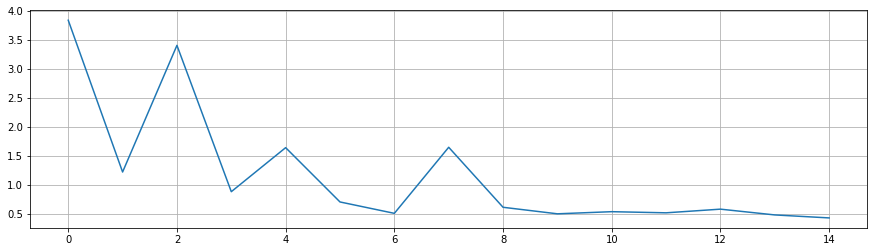

In [309]:
pl.figure(figsize=(15,4))
pl.plot(-MSE)
#pl.plot(MSE)
pl.grid()

## Testing and saving output

In [18]:
output = np.argmax(nn.predict(test_data1),1)

In [23]:
output[:100]

array([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 5, 3, 4, 1, 2, 2, 8, 0, 2, 7,
       7, 5, 1, 2, 6, 0, 9, 3, 8, 8, 3, 3, 8, 0, 7, 5, 7, 9, 0, 1, 6, 7,
       6, 5, 2, 1, 2, 2, 4, 2, 5, 8, 2, 2, 8, 2, 8, 0, 7, 7, 8, 5, 1, 1,
       0, 4, 7, 8, 7, 0, 2, 6, 2, 3, 1, 2, 8, 4, 1, 8, 5, 9, 5, 0, 3, 2,
       0, 2, 5, 3, 6, 7, 1, 8, 0, 1, 2, 2])

In [ ]:
with h5py.File('predicted_labels.h5','w') as H: H.create_dataset('label',data=output)